# AI Agent - Dynamic Tools

In this notebook we will build an AI Agent that can also generate dynamic code to solve a problem, and not only rely on pre-built tools. For the example, we will add visualization option to our SQL expert agent. 

We will:

* [Reuse the local SQL Database](#reuse-local-sql-database)
* [Adjust the system prompt](#adjusting-the-system-prompt)
* [Add dynamic code tool](#add-dynamic-code-tool-to-the-sql-tools)
* [Create secure sandbox exnvironment](#creating-a-secure-sandbox-to-the-code-execution)
* [Add the new dynmaic tool to the script](#add-the-new-tool-to-chat-script)

### Visual improvements

We will use [rich library](https://github.com/Textualize/rich), and `rich-theme-manager` to make the output more readable, and supress warning messages.

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Reuse local SQL database

We will reuse the local SQLite database that we created in the previous hands-on lab, and also reuse the SQLDatabase class that we defined there.

In [3]:
import sqlite3
import json

class SQLDatabase:
    def __init__(self):
        self.db_name = 'baseball.db'

    def get_db_schema(self):
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        # Get schema for player table
        cursor.execute("PRAGMA table_info(player)")
        player_schema = cursor.fetchall()
        
        # Get schema for salary table 
        cursor.execute("PRAGMA table_info(salary)")
        salary_schema = cursor.fetchall()
        
        conn.close()
        
        return json.dumps({
            'player': player_schema,
            'salary': salary_schema
        })    

    def execute_sql_query(self, sql_query: str):
    
        # Connect to SQLite database
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        # Execute query
        cursor.execute(sql_query)
        
        # Fetch results
        results = cursor.fetchall()
        
        # Get column names
        column_names = [description[0] for description in cursor.description]
        
        # Convert results to list of dicts
        results_list = []
        for row in results:
            row_dict = dict(zip(column_names, row))
            results_list.append(row_dict)
            
        # Close connection
        conn.close()
        
        # Return JSON string
        return json.dumps(results_list)

In [4]:
db = SQLDatabase()
db.execute_sql_query("SELECT count(*) FROM player")

'[{"count(*)": 18846}]'

## Adjusting the System Prompt

We used before a short system prompt that was fine for the simple SQL flow. We will extend the prompt to allow the AI agent to geenrate visualization by generating python code dynamically. 

In [5]:
system_prompt = """
You are an expert business analyst with deep knowledge of SQL and visualization code in Python.
Your job is to help users understand and analyze their internal baseball data.
Be helpful and brief in your responses.
You have access to a set of tools, but only use them when needed. 
You also have access to a tool that allows execution of python code. Use it to generate the visualizations in your analysis.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

In [6]:
from dotenv import load_dotenv

load_dotenv()

True

## Add Dynamic Code Tool to the SQL tools

We will add to the `Tools` that can query the SQL database:
* Schema Tool - describes to the LLM what is the schema of the database
* SQL Query Tool - executes the SQL query that is requested by the LLM
Additional tool:
* Execute Code Tool - executes the visualization code that is requested by the LLM

In [7]:
tools = [
    {
        "name": "get_db_schema",
        "description": "Describe the schema of the SQLite database, including table names, and column names and types.",
        "input_schema": {
            "type": "object",
            "properties": {}
        }
    },
    {
        "name": "execute_sql_query",
        "description": "Return the query results of the given SQL query to the SQLite database.",
        "input_schema":  {
            "type": "object",
            "properties": {
                "sql_query": {
                    "type": "string",
                    "description": "The sql query to execute against the SQLite database"
                },
            },
            "required": ["sql_query"]
        }
    }
]

In [8]:
tools.append(
    {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "input_schema": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "The python code to execute in a single cell."
                }
            },
            "required": ["code"]
        }
    }
)

### Creating a secure sandbox to the code execution

We will use [E2B](https://e2b.dev/) service to execute the dynamic code for the AI agent.

In [9]:
from e2b_code_interpreter import Sandbox

# TODO: Get your E2B API key from https://e2b.dev/docs and add it to the local .env file

def code_interpret(code):
  console.print("Running code interpreter...")

  with Sandbox() as code_interpreter:
    exec = code_interpreter.run_code(code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

    if exec.error:
      print("[Code Interpreter ERROR]", exec.error)
    else:
      return exec.results    



In [10]:
code_interpret("1+1")

Running code interpreter...

[Result(2)]

## Add the new tool to chat script

We will add the option to call the `execute_code`, print nicely the Python code that was generated and executed, and finally display the visualization chart.

In [11]:
def process_tool_call(tool_name, tool_input):
    if tool_name == "get_db_schema":
        return db.get_db_schema()
    elif tool_name == "execute_sql_query":
        return db.execute_sql_query(tool_input["sql_query"])
    elif tool_name == "execute_python":
        return code_interpret(tool_input["code"])
    return []


In [12]:
import anthropic

anthropic_client = anthropic.Anthropic()

In [13]:
from rich.syntax import Syntax

def simple_chat(user_message: str):
    system_prompt = system_prompt
    # user_message = input("\nUser: ")
    messages = [{"role": "user", "content": user_message}]
    response = None
    while not response or not response.stop_reason == "end_turn":
        #If the last message is from the assistant, get another input from the user
        if messages[-1].get("role") == "assistant":
            # user_message = input("\nUser: ")
            messages.append({"role": "user", "content": user_message})

        #Send a request to Claude
        response = anthropic_client.messages.create(
            system = system_prompt,
            model="claude-3-5-sonnet-20241022",
            max_tokens=4096,
            tools=tools,
            messages=messages
        )
        # Update messages to include Claude's response
        messages.append(
            {"role": "assistant", "content": response.content}
        )

        #If Claude stops because it wants to use a tool:
        if response.stop_reason == "tool_use":
            tool_use = response.content[-1] #Naive approach assumes only 1 tool is called at a time
            tool_name = tool_use.name
            tool_input = tool_use.input
            console.print(f"[bright_yellow]======Claude wants to use the {tool_name} tool======[/bright_yellow]")
            if tool_name == "execute_sql_query":
                syntax = Syntax(tool_input['sql_query'], "sql", line_numbers=True)
                console.print(syntax)
            elif tool_name == "execute_python":
                syntax = Syntax(tool_input['code'], "python", line_numbers=True)
                console.print(syntax)

            #Actually run the underlying tool functionality on our db
            tool_result = process_tool_call(tool_name, tool_input)

            if tool_name == "execute_python":
                display(tool_result[0])

            #Add our tool_result message:
            messages.append(
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "tool_result",
                            "tool_use_id": tool_use.id,
                            "content": str(tool_result),
                        }
                    ],
                },
            )
        else: 
            #If Claude does NOT want to use a tool, just print out the text reponse
            console.print("\nAnswer: " + f"[bright_green]{response.content[0].text}[/bright_green]" )


In [14]:
user_prompt = """
What were the top 10 states where baseball players were born in the 80's and compare it to the 70's? 
Please show the results with a bar chart.
"""

======Claude wants to use the get_db_schema tool======

======Claude wants to use the execute_sql_query tool======

   1 WITH seventies AS (                                                                                           
   2   SELECT birth_state, COUNT(*) as count_70s                                                                   
   3   FROM player                                                                                                 
   4   WHERE birth_year >= 1970 AND birth_year < 1980                                                              
   5     AND birth_country = 'USA'                                                                                 
   6     AND birth_state IS NOT NULL                                                                               
   7   GROUP BY birth_state                                                                                        
   8 ),                                                                                                            
   9 eighties AS (                                                                                                 
  10   SELECT birth_state, COUNT(*) as count_80s                                                                   
  11   FROM player                                                                                                 
  12   WHERE birth_year >= 1980 AND birth_year < 1990                                                              
  13     AND birth_country = 'USA'                                                                                 
  14     AND birth_state IS NOT NULL                                                                               
  15   GROUP BY birth_state                                                                                        
  16 )                                                                                                             
  17 SELECT                                                                                                        
  18   COALESCE(s.birth_state, e.birth_state) as state,                                                            
  19   COALESCE(s.count_70s, 0) as players_70s,                                                                    
  20   COALESCE(e.count_80s, 0) as players_80s                                                                     
  21 FROM seventies s                                                                                              
  22 FULL OUTER JOIN eighties e ON s.birth_state = e.birth_state                                                   
  23 WHERE COALESCE(s.count_70s, 0) > 0 OR COALESCE(e.count_80s, 0) > 0                                            
  24 ORDER BY (COALESCE(s.count_70s, 0) + COALESCE(e.count_80s, 0)) DESC                                           
  25 LIMIT 10;                                                                                                     

======Claude wants to use the execute_python tool======

   1 import pandas as pd                                                                                           
   2 import matplotlib.pyplot as plt                                                                               
   3                                                                                                               
   4 # Create the data                                                                                             
   5 data = {                                                                                                      
   6     'State': ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'OH', 'PA', 'AL', 'NJ'],                                    
   7     '1970s': [334, 106, 101, 79, 47, 71, 57, 51, 34, 32],                                                     
   8     '1980s': [334, 169, 148, 55, 61, 35, 48, 37, 30, 30]                                                      
   9 }                                                                                                             
  10                                                                                                               
  11 df = pd.DataFrame(data)                                                                                       
  12                                                                                                               
  13 # Create the bar chart                                                                                        
  14 plt.figure(figsize=(12, 6))                                                                                   
  15 x = range(len(df['State']))                                                                                   
  16 width = 0.35                                                                                                  
  17                                                                                                               
  18 plt.bar([i - width/2 for i in x], df['1970s'], width, label='1970s', color='skyblue')                         
  19 plt.bar([i + width/2 for i in x], df['1980s'], width, label='1980s', color='lightcoral')                      
  20                                                                                                               
  21 plt.xlabel('State')                                                                                           
  22 plt.ylabel('Number of Players')                                                                     

Running code interpreter...

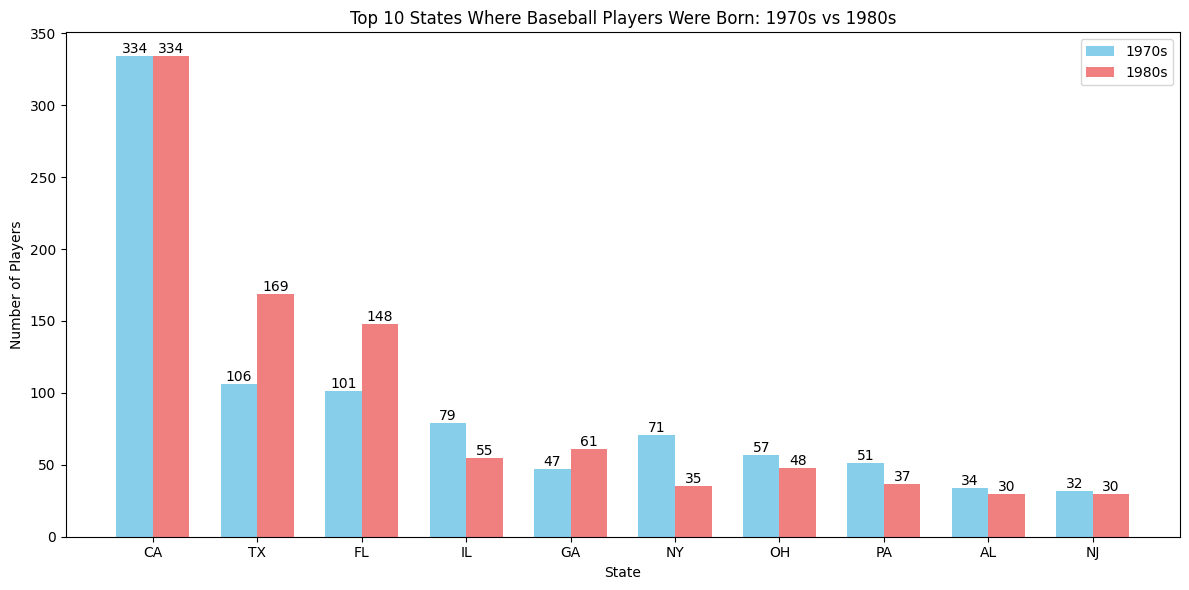

Answer: Based on the analysis, here are the key findings:

1. California (CA) was by far the most common birthplace for baseball players in both decades, with exactly 334 
players born there in each decade.

2. Texas (TX) and Florida (FL) were the next most common birthplaces, and both states saw significant increases 
from the 1970s to the 1980s:
   - Texas: 106 → 169 players (59.4% increase)
   - Florida: 101 → 148 players (46.5% increase)

3. Some states saw notable decreases from the 1970s to 1980s:
   - New York (NY): 71 → 35 players (50.7% decrease)
   - Illinois (IL): 79 → 55 players (30.4% decrease)
   - Pennsylvania (PA): 51 → 37 players (27.5% decrease)

4. Georgia (GA) was one of the few states that saw an increase, going from 47 players in the 1970s to 61 in the 
1980s.

5. Alabama (AL) and New Jersey (NJ) remained relatively stable, with only slight decreases in the number of players
born there.

This data shows a clear shift in baseball talent production from traditional northern baseball states (NY, IL, PA) 
to southern states (TX, FL, GA) during this period, while California maintained its position as the dominant 
producer of baseball players.

In [15]:
simple_chat(user_prompt)